In [3]:
from collections import defaultdict
import numpy as np
import pandas as pd
import gzip
import json
from tqdm import tqdm

In [4]:
def Cos_sim(item_a_rate_all, item_b_rate_all):
    # item_a_rate_all: {user_id: rate, ...}
    # item_b_rate_all: {user_id: rate, ...}
    # dot product of shared users ratings of item a and item b

    # if shared_users is empty, return 0
    

    shared_users = set(item_a_rate_all.keys()).intersection(set(item_b_rate_all.keys()))


    numerator = 0
    for user in shared_users:
        numerator += item_a_rate_all[user] * item_b_rate_all[user]
    denominator = np.sqrt(sum([rate**2 for rate in item_a_rate_all.values()])) * np.sqrt(sum([rate**2 for rate in item_b_rate_all.values()]))
    # check if denominator is zero
    if denominator == 0:
        return 0
    return numerator / denominator

In [5]:
def Jaccard(s1, s2):
    if len(s1) == 0 or len(s2) == 0:
        return 0
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

In [6]:
with gzip.open("./data/train.json.gz", 'rt', encoding='utf-8') as gzip_file:
    for line in gzip_file:
        train = json.loads(line)

In [7]:
with gzip.open("./data/val.json.gz", 'rt', encoding='utf-8') as gzip_file:
    for line in gzip_file:
        valid = json.loads(line)

In [47]:
# downsample train set
# train = train[:100000]

In [8]:
itemUsersrate_train = defaultdict(dict)
userItemsrate_train = defaultdict(dict)
itemUsersrate_valid = defaultdict(dict)
userItemsrate_valid = defaultdict(dict)


for i in range(len(train)):
    # for each item, create a dict of users who rated it and their ratings
    itemUsersrate_train[train[i]['asin']][train[i]['reviewerID']] = train[i]['overall']
    # for each user, create a dict of items they have rated and the ratings
    userItemsrate_train[train[i]['reviewerID']][train[i]['asin']] = train[i]['overall']

for i in range(len(valid)):
    # for each item, create a dict of users who rated it and their ratings
    itemUsersrate_valid[valid[i]['asin']][valid[i]['reviewerID']] = valid[i]['overall']
    # for each user, create a dict of items they have rated and the ratings
    userItemsrate_valid[valid[i]['reviewerID']][valid[i]['asin']] = valid[i]['overall']

In [71]:
# count of items that only bought by less than 5 users
count = 0
for item in itemUsersrate_train:
    if len(itemUsersrate_train[item]) == 1:
        count += 1
print("count of items that only bought by less than 5 users: ", count)

count of items that only bought by less than 5 users:  58704


In [450]:
item_count = []
for item in itemUsersrate_train:
    item_count.append(len(itemUsersrate_train[item]))

# plot item_count
import matplotlib.pyplot as plt
plt.hist([i for i in item_count if i < 100 and i >=10], bins = 99)
plt.xlabel('number of users who bought the item')
plt.ylabel('number of items')
plt.title('item_count')
plt.savefig('item_count.png',dpi=300)


In [434]:
# exclude items that only bought by less than or equal to 5 users
itemUsersrate_train_ds = {item: itemUsersrate_train[item] for item in itemUsersrate_train if len(itemUsersrate_train[item]) > 80}
# create a jaccard similarity dict for each item
item_jaccard = defaultdict(dict)
for item_a in tqdm(itemUsersrate_train_ds):
    for item_b in itemUsersrate_train_ds:
        # check if this pair is already calculated
        if item_b in item_jaccard[item_a]:
            continue
        if item_a != item_b:
            item_jaccard[item_a][item_b] = Jaccard(set(itemUsersrate_train_ds[item_a].keys()), set(itemUsersrate_train_ds[item_b].keys()))

# save item_jaccard to local pickle file
import pickle
with open('./item_jaccard.pickle', 'wb') as handle:
    pickle.dump(item_jaccard, handle, protocol=pickle.HIGHEST_PROTOCOL)


100%|██████████| 8345/8345 [2:16:30<00:00,  1.02it/s]    


In [435]:
# load item_jaccard from local pickle file
with open('./item_jaccard.pickle', 'rb') as handle:
    item_jaccard = pickle.load(handle)

In [9]:
user_item_time_train = defaultdict(dict)
user_item_time_valid = defaultdict(dict)
for i in range(len(train)):
    user_item_time_train[train[i]['reviewerID']][train[i]['asin']] = train[i]['unixReviewTime']
for i in range(len(valid)):
    user_item_time_valid[valid[i]['reviewerID']][valid[i]['asin']] = valid[i]['unixReviewTime']

In [10]:
newtrain =[]
user_dict1 = defaultdict(set)
my_dict1 = defaultdict(list)
item_set = set()
# remove items that has user and id pair in s
for i in train:
    if i['asin'] in item_jaccard.keys():
        newtrain.append({"reviewerID": i['reviewerID'],
        "asin": i["asin"],
        "overall": i["overall"],
        "unixReviewTime": i["unixReviewTime"]
        })
        my_dict1[(i['reviewerID'],i['asin'])] = i['overall']
        user_dict1[i['reviewerID']].add(i['asin'])
        item_set.add(i['asin'])


In [11]:
def time_func(t, lbda):
    return np.exp(-lbda * t)

global_avg = np.mean([train[i]['overall'] for i in range(len(train))])

In [12]:
res =[]
# remove items that has user and id pair in s
for i in newtrain:
    if i['asin'] in item_jaccard.keys():
        res.append(i["overall"])

In [61]:

# for each user item pari in train
for k in [i*0.0000001 for i in range(1,2)]:
    predictions = []
    for i in tqdm(newtrain):
        user = i['reviewerID']
        i1 = i['asin']
        numerator = 0
        denominator = 0
        for i2 in user_dict1[user]:
            # for each item that user has rated
            if i2 not in item_jaccard.keys() or i2 == i1:
                continue
            else:
                
                # calculate the weight
                weight = time_func(user_item_time_train[user][i2], k)
                # calculate the numerator
                sim = item_jaccard[i1][i2]
                numerator += weight * sim * userItemsrate_train[user][i2]
                denominator += weight * sim
            # calculate the prediction
        if denominator == 0:
            predictions.append(global_avg)
        else:
            predictions.append(numerator / denominator)

    print(k, sum([(res[i]-predictions[i])**2 for i in range(len(predictions))])/len(predictions))

100%|██████████| 2750676/2750676 [02:15<00:00, 20345.83it/s]


1e-07 1.972770635558518


In [62]:
y_pred = [round(i) for i in predictions]
y_true = [round(i) for i in res]
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.36016455591280105

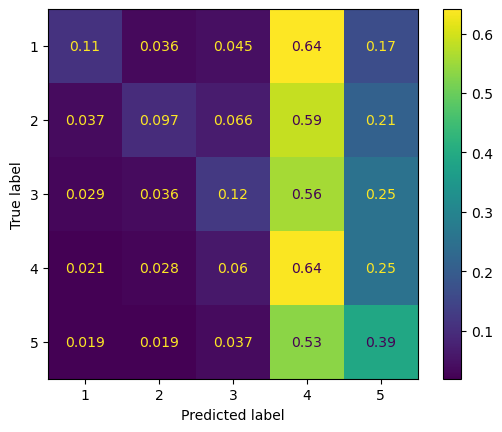

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred,normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[1,2,3,4,5])
disp.plot()

disp.figure_.savefig('time_cm.png',dpi=300)

In [489]:
user_item_time_train['A1CAQRGX73Z1M9']

{'B0015ZK5K4': 1355184000, 'B001NIZAH6': 1363046400, 'B001AZQXGY': 1261353600}

In [529]:
predictions

[4.0,
 1.0,
 5.0,
 4.149322543000375,
 1.0,
 4.999999999999999,
 4.149322543000375,
 5.0,
 4.149322543000375,
 5.0,
 4.149322543000375,
 5.0,
 4.0,
 4.149322543000375,
 4.149322543000375,
 4.149322543000375,
 2.999999999999999,
 5.0,
 4.0,
 1.0,
 2.0,
 5.0,
 5.0,
 4.0,
 5.000000000000001,
 4.999999999999999,
 4.149322543000375,
 5.0,
 5.0,
 3.000000000000001,
 4.149322543000375,
 2.0,
 5.0,
 4.149322543000375,
 5.0,
 4.149322543000375,
 4.149322543000375,
 4.149322543000375,
 4.149322543000375,
 5.0,
 5.0,
 4.149322543000375,
 4.149322543000375,
 4.0,
 1.0,
 4.149322543000375,
 5.0,
 5.000000000000002,
 4.999999999999999,
 4.149322543000375,
 4.149322543000375,
 4.999999999999999,
 5.0,
 5.0,
 5.000000000000001,
 5.0,
 4.149322543000375,
 4.149322543000375,
 5.0,
 4.149322543000375,
 5.000000000000001,
 4.149322543000375,
 5.0,
 5.0,
 4.149322543000375,
 5.0,
 5.0,
 5.0,
 4.149322543000375,
 4.149322543000375,
 4.999999999999999,
 5.0,
 2.9999999999999996,
 4.149322543000375,
 3.000000

In [482]:
'B0015ZK5K4' in item_jaccard.keys()

True

In [481]:
'B0015ZK5K4' in item_jaccard['B0015ZK5K4'].keys()

False

In [474]:
len(item_jaccard['B01CO9582Y'].keys())

8344

In [ ]:
# calculate mean squared error between predictions and valid
rmse = (sum([(predictions[i]-res[i])**2 for i in range(len(predictions))])/len(predictions))**0.5
print("rmse: ", rmse)

In [451]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm=confusion_matrix(res, predictions,labels=[1,2,3,4,5],normalize='true')
cmd = ConfusionMatrixDisplay(cm, display_labels=[1,2,3,4,5])
#save cmd plot 
cmd.plot()

ValueError: Found input variables with inconsistent numbers of samples: [914642, 903830]

In [326]:
user_item_time_valid['AAJJB78E9IRZS']["B00QYWTGEE"]

1456790400

In [250]:
prediction_class = [round(i) for i in predictions]
res_class = [round(i) for i in res]
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(res_class, prediction_class)
sum(cm.diagonal())/cm.sum()

0.15887884354124607

In [5]:
# for each user, get all the asin, and the time they bought it
user_asin = defaultdict(list)
for i in range(len(train)):
    user_asin[train[i]['reviewerID']].append((train[i]['asin'], train[i]['unixReviewTime']))